In [60]:
import os
import sys
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation 

path = pathlib.Path(os.getcwd())
sys.path.append(str(path) + '/')

from pymdp.agent import Agent
from pymdp import utils, maths

from IPython.display import HTML, Image


In [2]:
# set up dimensionalities of the generative model and environment

grid_dims = [5, 7] # dimensions of the grid
num_grid_points = np.prod(grid_dims)

# create a look-up table mapping linear indices to (y, x) tuples
grid = np.arange(num_grid_points).reshape(grid_dims)
it = np.nditer(grid, flags=["multi_index"])

loc_list = []
while not it.finished:
    loc_list.append(it.multi_index)
    it.iternext()

cue1_location = (2, 0)
# cue2_locations = [(1, 3), (1, 5), (3, 3), (3, 5)]
cue2_locations = [(0, 2), (1, 3), (3, 3), (4, 2)]

reward_conditions = ["TOP", "BOTTOM"]
# reward_locations = [(0, 4), (4, 4)]
reward_locations = [(1, 5), (3, 5)]

num_states = [num_grid_points, len(cue2_locations), len(reward_conditions)]

cue1_names = ['Null', 'Cue 1', 'Cue 2', 'Cue 3', 'Cue 4'] # different possible cue identities at cue1 location
cue2_names = ['Null', 'reward_on_top', 'reward_on_bottom']

reward_names = ['Null', '+5', '-10']

num_obs = [num_grid_points, len(cue1_names), len(cue2_names), len(reward_names)]

In [3]:
# A matrix
A_m_shapes = [ [o_dim] + num_states for o_dim in num_obs]
A = utils.obj_array_zeros(A_m_shapes)

# make the location observation only depend on the location state (proprioceptive observation modality)
A[0] = np.tile(np.expand_dims(np.eye(num_grid_points), (-2, -1)), (1, 1, num_states[1], num_states[2]))

# make the cue1 observation depend on the location (being at cue1_location) and the true location of cue2
A[1][0,:,:,:] = 1.0 # default makes Null the most likely observation everywhere

for i, cue_loc2_i in enumerate(cue2_locations):
    A[1][0,loc_list.index(cue1_location),i,:] = 0.0
    A[1][i+1,loc_list.index(cue1_location),i,:] = 1.0

# make the cue2 observation depend on the location (being at the correct cue2_location) and the reward condition
A[2][0,:,:,:] = 1.0 # default makes Null the most likely observation everywhere

for i, cue_loc2_i in enumerate(cue2_locations):

    # if the cue2-location is the one you're currently at, then you get a signal about where the reward is
    A[2][0,loc_list.index(cue_loc2_i),i,:] = 0.0 
    A[2][1,loc_list.index(cue_loc2_i),i,0] = 1.0
    A[2][2,loc_list.index(cue_loc2_i),i,1] = 1.0
    
# make the reward observation depend on the location (being at reward location) and the reward condition
A[3][0,:,:,:] = 1.0 # default makes Null the most likely observation everywhere

A[3][0,loc_list.index(reward_locations[0]),:,:] = 0.0
A[3][1,loc_list.index(reward_locations[0]),:,0] = 1.0
A[3][2,loc_list.index(reward_locations[0]),:,1] = 1.0

A[3][0,loc_list.index(reward_locations[1]),:,:] = 0.0
A[3][1,loc_list.index(reward_locations[1]),:,1] = 1.0
A[3][2,loc_list.index(reward_locations[1]),:,0] = 1.0

In [4]:
# B matrix

num_controls = [5, 1, 1]
B_f_shapes = [ [ns, ns, num_controls[f]] for f, ns in enumerate(num_states)]

B = utils.obj_array_zeros(B_f_shapes)
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

for action_id, action_label in enumerate(actions):

  for curr_state, grid_location in enumerate(loc_list):

    y, x = grid_location

    if action_label == "UP":
      next_y = y - 1 if y > 0 else y 
      next_x = x
    elif action_label == "DOWN":
      next_y = y + 1 if y < (grid_dims[0]-1) else y 
      next_x = x
    elif action_label == "LEFT":
      next_x = x - 1 if x > 0 else x 
      next_y = y
    elif action_label == "RIGHT":
      next_x = x + 1 if x < (grid_dims[1]-1) else x 
      next_y = y
    elif action_label == "STAY":
      next_x = x
      next_y = y

    new_location = (next_y, next_x)
    next_state = loc_list.index(new_location)
    B[0][next_state, curr_state, action_id] = 1.0

B[1][:,:,0] = np.eye(num_states[1])
B[2][:,:,0] = np.eye(num_states[2])


In [5]:
# C vector
C = utils.obj_array_zeros(num_obs)

C[3][1] = 2.0
C[3][2] = -4.0

In [6]:
# D vector
D = utils.obj_array_uniform(num_states)
D[0] = utils.onehot(loc_list.index((2,2)), num_grid_points)

In [7]:
class GridWorldEnv():
    
    def __init__(self,starting_loc = (4,0), cue1_loc = (2, 0), cue2 = 'Cue 1', reward_condition = 'TOP'):

        self.init_loc = starting_loc
        self.current_location = self.init_loc

        self.cue1_loc = cue1_loc
        self.cue2_name = cue2
        self.cue2_loc_names = ['Cue 1', 'Cue 2', 'Cue 3', 'Cue 4']
        self.cue2_loc = cue2_locations[self.cue2_loc_names.index(self.cue2_name)]

        self.reward_condition = reward_condition
        print(f'Starting location is {self.init_loc}, Reward condition is {self.reward_condition}, cue is located in {self.cue2_name}')
    
    def step(self,action_label):

        (Y, X) = self.current_location

        if action_label == "UP": 
          
          Y_new = Y - 1 if Y > 0 else Y
          X_new = X

        elif action_label == "DOWN": 

          Y_new = Y + 1 if Y < (grid_dims[0]-1) else Y
          X_new = X

        elif action_label == "LEFT": 
          Y_new = Y
          X_new = X - 1 if X > 0 else X

        elif action_label == "RIGHT": 
          Y_new = Y
          X_new = X +1 if X < (grid_dims[1]-1) else X

        elif action_label == "STAY":
          Y_new, X_new = Y, X 
        
        self.current_location = (Y_new, X_new) # store the new grid location

        loc_obs = self.current_location # agent always directly observes the grid location they're in 

        if self.current_location == self.cue1_loc:
          cue1_obs = self.cue2_name
        else:
          cue1_obs = 'Null'

        if self.current_location == self.cue2_loc:
          cue2_obs = cue2_names[reward_conditions.index(self.reward_condition)+1]
        else:
          cue2_obs = 'Null'
        
        if self.current_location == reward_locations[0]:
          if self.reward_condition == 'TOP':
            reward_obs = '+5'
          else:
            reward_obs = '-10'
        elif self.current_location == reward_locations[1]:
          if self.reward_condition == 'BOTTOM':
            reward_obs = '+5'
          else:
            reward_obs = '-10'
        else:
          reward_obs = 'Null'

        return loc_obs, cue1_obs, cue2_obs, reward_obs

    def reset(self):
        self.current_location = self.init_loc
        print(f'Re-initialized location to {self.init_loc}')
        loc_obs = self.current_location
        cue1_obs = 'Null'
        cue2_obs = 'Null'
        reward_obs = 'Null'

        return loc_obs, cue1_obs, cue2_obs, reward_obs
    
env = GridWorldEnv()

Starting location is (4, 0), Reward condition is TOP, cue is located in Cue 1


In [8]:
my_agent = Agent(A = A, B = B, C = C, D = D, policy_len = 4)

In [9]:
my_env = GridWorldEnv(starting_loc = (2,2), cue1_loc = (2, 0), cue2 = 'Cue 3', reward_condition = 'TOP')
loc_obs, cue1_obs, cue2_obs, reward_obs = my_env.reset()
  
history_of_locs = [loc_obs]
history_of_beliefs = []
obs = [loc_list.index(loc_obs), cue1_names.index(cue1_obs), cue2_names.index(cue2_obs), reward_names.index(reward_obs)]
for t in range(10):

    qs = my_agent.infer_states(obs)
    # print(f'Beliefs about own location at time {t}: {qs[0].round(3)}')
    # print(f'Beliefs about cue2 location at time {t}: {qs[1].round(3)}')
    # print(f'Beliefs about reward condition at time {t}: {qs[2].round(3)}')

    history_of_beliefs.append(qs)

    my_agent.infer_policies()
    chosen_action_id = my_agent.sample_action()

    movement_id = int(chosen_action_id[0])

    choice_action = actions[movement_id]

    loc_obs, cue1_obs, cue2_obs, reward_obs = my_env.step(choice_action)

    obs = [loc_list.index(loc_obs), cue1_names.index(cue1_obs), cue2_names.index(cue2_obs), reward_names.index(reward_obs)]

    history_of_locs.append(loc_obs)

    print(f'Location at time {t+1}: {loc_obs}')
    print(f'Cue1 observation at time {t+1}: {cue1_obs}')
    print(f'Cue2 observation at time {t+1}: {cue2_obs}')
    print(f'Reward at time {t+1}: {reward_obs}')


Starting location is (2, 2), Reward condition is TOP, cue is located in Cue 3
Re-initialized location to (2, 2)
Location at time 1: (2, 1)
Cue1 observation at time 1: Null
Cue2 observation at time 1: Null
Reward at time 1: Null
Location at time 2: (2, 0)
Cue1 observation at time 2: Cue 3
Cue2 observation at time 2: Null
Reward at time 2: Null
Location at time 3: (2, 1)
Cue1 observation at time 3: Null
Cue2 observation at time 3: Null
Reward at time 3: Null
Location at time 4: (2, 2)
Cue1 observation at time 4: Null
Cue2 observation at time 4: Null
Reward at time 4: Null
Location at time 5: (3, 2)
Cue1 observation at time 5: Null
Cue2 observation at time 5: Null
Reward at time 5: Null
Location at time 6: (3, 3)
Cue1 observation at time 6: Null
Cue2 observation at time 6: reward_on_top
Reward at time 6: Null
Location at time 7: (2, 3)
Cue1 observation at time 7: Null
Cue2 observation at time 7: Null
Reward at time 7: Null
Location at time 8: (2, 4)
Cue1 observation at time 8: Null
Cue2 o

In [58]:
print(history_of_beliefs[4][1].round(3))
print(history_of_beliefs[4][2].round(3))

[0. 0. 0. 1.]
[0.5 0.5]


In [47]:
history_of_locs

[(2, 2),
 (2, 1),
 (2, 0),
 (2, 1),
 (2, 2),
 (3, 2),
 (3, 3),
 (2, 3),
 (2, 4),
 (1, 4),
 (1, 5)]

In [67]:
np.array(history_of_locs)

array([[2, 2],
       [2, 1],
       [2, 0],
       [2, 1],
       [2, 2],
       [3, 2],
       [3, 3],
       [2, 3],
       [2, 4],
       [1, 4],
       [1, 5]])

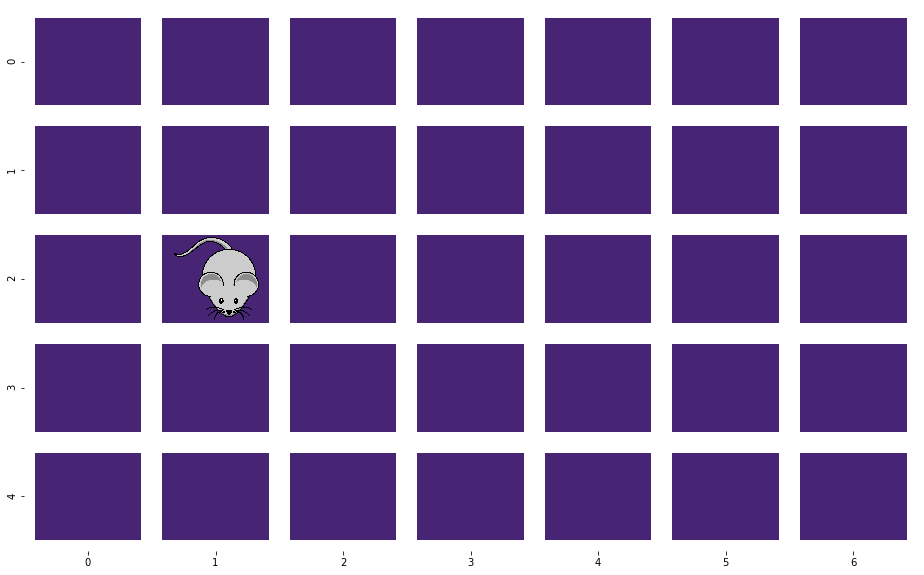

In [76]:
fig, ax = plt.subplots(figsize=(16, 10))
h = sns.heatmap(0.1 + np.zeros(grid_dims), cmap='viridis', vmax=1., vmin=0.0, linewidth = 20.0, cbar=False, ax=ax)

img1 = plt.imread('mouse_img.png')
im1 = OffsetImage(img1, zoom=0.042)

ab1 = AnnotationBbox(im1, (history_of_locs[0][1] - 0.5, history_of_locs[0][0] + 0.5), xycoords='data', frameon=False)
an1 = ax.add_artist(ab1)

an1.xy = (history_of_locs[1][1] - 0.5, history_of_locs[1][0] + 0.5)
an1.xybox = (history_of_locs[1][1] - 0.5, history_of_locs[1][0] + 0.5)

def init():
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    sns.despine(top=True, right=True, left=True, bottom=True)
    fig.tight_layout()
    return h, an1

def update(frame):
    ydata1, xdata1 = frame
    an1.xy = (xdata1 - 0.5, ydata1 + 0.5)
    an1.xybox = (xdata1 - 0.5, ydata1 + 0.5)

    return h, an1

anim = FuncAnimation(fig, update, frames=np.array(history_of_locs[1:]), init_func=init, blit=True)
anim.save('demo_icons.gif', writer = 'imagemagick')

In [ ]:

# shape = (n_x, n_y)
# loc = np.ravel_multi_index(seek_sequence[0], shape)


# frames = np.concatenate([np.array(seek_sequence),
#                          np.array(hide_sequence)], -1)

# img1 = plt.imread('mouse_img.png')
# im1 = OffsetImage(img1, zoom=0.3)

# ab1 = AnnotationBbox(im1, (frames[0][1], frames[0][0]), xycoords='data', frameon=False)
# an1 = ax.add_artist(ab1)

# ab2 = AnnotationBbox(im2, (frames[0][-1], frames[0][-2]), xycoords='data', frameon=False)
# an2 = ax.add_artist(ab2)

# def init():
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])
#     sns.despine(top=True, right=True, left=True, bottom=True)
#     fig.tight_layout()
#     return h, an1, an2

# def update(frame):
#     ydata1, xdata1, ydata2, xdata2 = frame
#     an1.xy = (xdata1, ydata1)
#     an1.xybox = (xdata1, ydata1)

#     an2.xy = (xdata2, ydata2)
#     an2.xybox = (xdata2, ydata2)

#     loc = np.ravel_multi_index((ydata1, xdata1), shape)
#     A = As_h[2][1][..., loc].reshape(n_x, n_y)
#     h.set_data(np.where(A == 1, 1, np.nan))

#     return h, an1, an2

# anim = FuncAnimation(fig, update, frames=frames, init_func=init, blit=True)
# anim.save('demo_icons.gif', writer='imagemagick', fps=5)